<a href="https://colab.research.google.com/github/Ajjme/Feedback_Systems/blob/main/Naked_Planet_ODE4u.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
fontsize=9
plt.rcParams['font.size'] = fontsize

In [2]:
def rhs_wrapped(t, x, u, c):
    """
    Wrapper for ode4u to compute temperature derivatives.
    x = [T_atm, T_ocn]
    u is unused here.
    c = depth
    """
    T_atm, T_ocn = x
    depth = c

    lambda_LW = 4/3  # W/m^2 per K (climate feedback parameter)
    c_atm = c_p * rho_w * 50  # J/K, effective atmosphere + upper ocean heat capacity
    dF = 4                   # W/m^2, radiative forcing
    c_ocn = c_p * rho_w * depth  # J/K, ocean heat capacity
    gamma = 1                # W/m^2K, ocean-atmosphere coupling

    dT_atm_dt = ((dF - lambda_LW * T_atm) - gamma * (T_atm - T_ocn)) / c_atm
    dT_ocn_dt = gamma * (T_atm - T_ocn) / c_ocn

    dxdt = np.array([dT_atm_dt, dT_ocn_dt])
    y = x  # here we just return the state itself as output
    return dxdt, y


def solve_ODE(depth):
    """
    Solve the ODE using ode4u for a given ocean depth.
    """
    # Run solver
    time_array, x_sol, x_drv, y_sol = ode4u(rhs_wrapped, times_save, np.array([0.0, 0.0]), c=depth)

    # Extract solutions
    T_atm_array = x_sol[0, :]   # atmosphere temp
    T_ocn_array = x_sol[1, :]   # ocean temp

    return T_ocn_array, T_atm_array, time_array / YEAR


In [3]:
def ode4u(odefun, time, x0, u=None, c=None):
    """
    Solve a system of nonhomogeneous ODEs using the 4th-order Runge-Kutta method.
    (it depends on not just time and state but also external inputs (u) and constanstant (c))

    Parameters:
        odefun : function (t, x, u, c) -> (dxdt, y)
            Function that returns state derivative and output.
        time : array-like, shape (p,)
            Time values at which the solution is computed.
        x0 : array-like, shape (n,)
            Initial state at time[0].
        u : array-like, shape (m, p), optional
            System forcing input sampled at each time step.
        c : any
            Optional constants passed to odefun.

    Returns:
        time : ndarray
        x_sol : ndarray, shape (n, p)
        x_drv : ndarray, shape (n, p)
        y_sol : ndarray, shape (m, p)
    """
    time = np.asarray(time)
    x0 = np.asarray(x0).flatten()
    points = len(time) #creates number of time steps

#create defaults if not provided
    if c is None:
        c = 0
    if u is None:
        u = np.zeros((1, points))
    else:
        u = np.asarray(u)
#verify inputs recieved are in 2D array shape
    if u.ndim == 1:
        u = u[np.newaxis, :]

    if u.shape[1] < points:
        pad_width = points - u.shape[1]
        u = np.pad(u, ((0, 0), (0, pad_width)), mode='constant')

    # Initial output
    #odefun is the user defined derivitive
    # give us np.array(dxdt), np.array([fi]) from the function above
    # dxdt is first deriviative estimate and fi (now y1) is the sliding friction force
    dxdt1, y1 = odefun(time[0], x0, u[:, 0], c)

#set up arrays
    n = x0.size
    m = np.asarray(y1).size

    x_sol = np.full((n, points), np.nan)
    x_drv = np.full((n, points), np.nan)
    y_sol = np.full((m, points), np.nan)

    x_sol[:, 0] = x0 #states
    x_drv[:, 0] = dxdt1 # dervs
    y_sol[:, 0] = y1 # outputs

# time steping loop and main integration
    for p in range(points - 1):
      # get pieces needed for rk4
        t = time[p]
        dt = time[p + 1] - t
        dt2 = dt / 2.0

        u_mid = (u[:, p] + u[:, p + 1]) / 2.0

# compute rk4 intermediate dervitives
        dxdt2, _ = odefun(t + dt2, x0 + dxdt1 * dt2, u_mid, c)
        dxdt3, _ = odefun(t + dt2, x0 + dxdt2 * dt2, u_mid, c)
        dxdt4, _ = odefun(t + dt,  x0 + dxdt3 * dt, u[:, p + 1], c)

# update the state using the intermediate derivities to get a more accurate result than just one derv
        x0 = x0 + (dxdt1 + 2 * (dxdt2 + dxdt3) + dxdt4) * dt / 6.0
# next level
# this gives us the next output from the provided differencial equation
        dxdt1, y1 = odefun(time[p + 1], x0, u[:, p + 1], c)

#than we put it into the array
        x_sol[:, p + 1] = x0 #state
        x_drv[:, p + 1] = dxdt1 #derv
        y_sol[:, p + 1] = y1 #output
        #safetly incase NaN or Inf
        if not np.all(np.isfinite(x0)):
            break

    return time, x_sol, x_drv, y_sol

In [4]:
########################################################################
# Main program
########################################################################
# set parameters:
# ---------------
YEAR = 31536000 # A year in seconds
YEARS_TO_RUN = 5000
T0, time_start = (0.0,0.0), 0.0 # initial values for (T_ocn, T_atm) and time:
time_end = YEAR * YEARS_TO_RUN #the maximum value of time
times_save = np.arange(time_start,time_end,YEAR/12) # times for saving ODE solution
N=len(times_save) #the number of points calculated
c_p = 4005 # J/kg, specific heat of seawater
rho_w = 1023.6 # kg/m^3, density of seawater
# solve for temperature in both cases:
# ------------------------------------
T_ocn_array_deep, T_atm_array_deep, time_array_deep = solve_ODE(depth=4000)
T_ocn_array_shallow,T_atm_array_shallow,time_array_shallow = solve_ODE(depth=40)
# print final results at 10 years and at steady state:
# ----------------------------------------------------
print("The temperatures of the atmosphere/ ocean for the case of a shallow ocean are:")
print("year=",time_array_shallow[120],",T_ocn=",T_ocn_array_shallow[120]\
,",T_atm=",T_atm_array_shallow[120])
print("year=",time_array_shallow[-1],",T_ocn=",T_ocn_array_shallow[-1]\
,",T_atm=",T_atm_array_shallow[-1])
print("The temperatures of the atmosphere/ ocean for the case of a deep ocean are:")
print("year=",time_array_deep[120],",T_ocn=",T_ocn_array_deep[120]\
,",T_atm=",T_atm_array_deep[120])
print("year=",time_array_deep[-1],",T_ocn=",T_ocn_array_deep[-1]\
,",T_atm=",T_atm_array_deep[-1])

The temperatures of the atmosphere/ ocean for the case of a shallow ocean are:
year= 10.0 ,T_ocn= 1.4328927779899667 ,T_atm= 2.1091962968934017
year= 4999.916666666667 ,T_ocn= 2.999999999999963 ,T_atm= 2.999999999999977
The temperatures of the atmosphere/ ocean for the case of a deep ocean are:
year= 10.0 ,T_ocn= 0.023894455240561087 ,T_atm= 1.6737992702262936
year= 4999.916666666667 ,T_ocn= 2.9874789259448007 ,T_atm= 2.9946173858741836


Text(0.0, 1.0, '(a)')

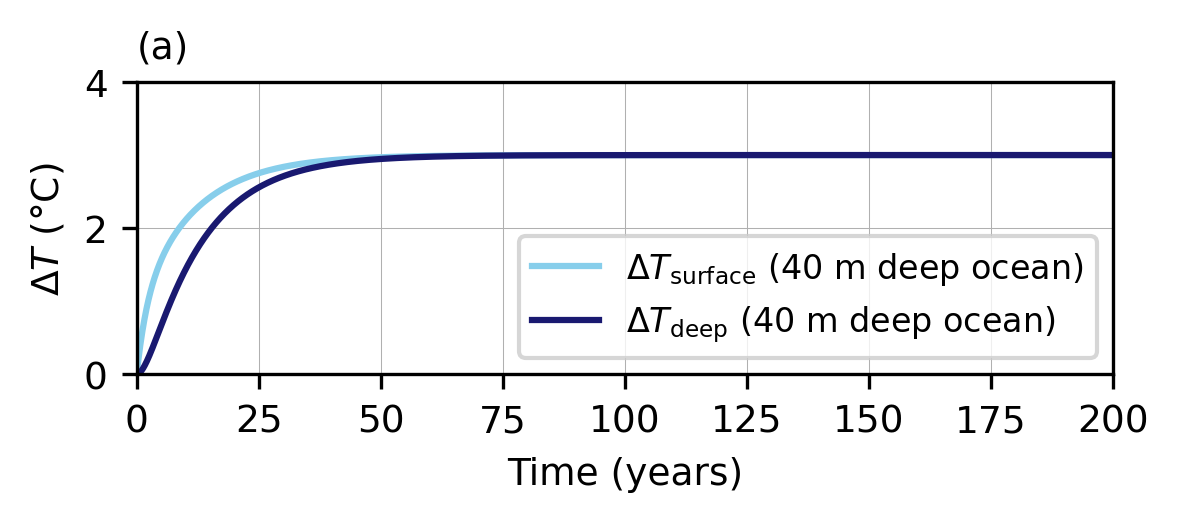

In [5]:
# Plot
fig=plt.figure(figsize=(4.2,4.3),dpi=300);
plt.subplot(3,1,1)
plt.plot(time_array_shallow, T_atm_array_shallow, "-", color='SkyBlue',
label="$\\Delta T_{\\rm surface}$ (40 m deep ocean)")
plt.plot(time_array_shallow, T_ocn_array_shallow, "-", color='MidnightBlue',
label="$\\Delta T_{\\rm deep}$ (40 m deep ocean)")
plt.ylabel('$\\Delta T$ (°C)')
plt.xlabel('Time (years)')
plt.xlim([0,200])
plt.ylim([0,4])
#plt.title('Atm/ Ocean temperature anomalies given a sudden 2x CO฀ increase')
plt.legend(loc='lower right',fontsize=fontsize-1)
plt.grid(lw=0.25)
plt.title("(a)",loc="left",fontsize=fontsize)

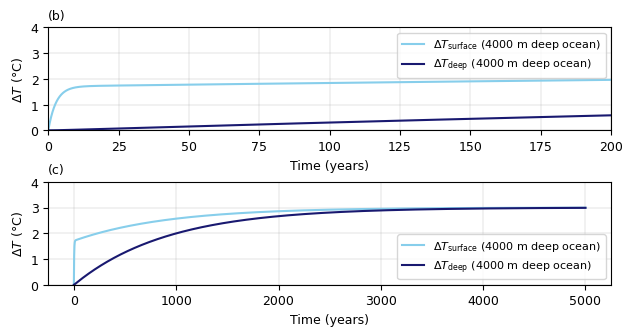

In [6]:
plt.subplot(3,1,2)
plt.plot(time_array_deep, T_atm_array_deep, "-", color='SkyBlue',
label="$\\Delta T_{\\rm surface}$ (4000 m deep ocean)")
plt.plot(time_array_deep, T_ocn_array_deep,"-", color='MidnightBlue',
label="$\\Delta T_{\\rm deep}$ (4000 m deep ocean)")
plt.ylabel('$\\Delta T$ (°C)')
plt.xlabel('Time (years)')
plt.xlim([0,200])
plt.ylim([0,4])
#plt.title('Atm/ Ocean temperature anomalies given a sudden 2x CO฀ increase')
plt.legend(loc='upper right',fontsize=fontsize-1)
plt.grid(lw=0.25)
plt.title("(b)",loc="left",fontsize=fontsize)
plt.subplot(3,1,3)
plt.plot(time_array_deep, T_atm_array_deep, "-", color='SkyBlue',
label="$\\Delta T_{\\rm surface}$ (4000 m deep ocean)")
plt.plot(time_array_deep, T_ocn_array_deep,"-", color='MidnightBlue',
label="$\\Delta T_{\\rm deep}$ (4000 m deep ocean)")
plt.ylabel('$\\Delta T$ (°C)')
plt.xlabel('Time (years)')
#plt.xlim([0,200])
plt.ylim([0,4])
#plt.title('Atm/ Ocean temperature anomalies given a sudden 2x CO฀ increase')
plt.legend(loc='lower right',fontsize=fontsize-1)
plt.grid(lw=0.25)
plt.title("(c)",loc="left",fontsize=fontsize)
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()